# Model evaluation

In this notebook, I will compare the accuracy metrics of models

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import scienceplots  # noqa # pylint: disable=unused-import

plt.style.use(["science", "ieee", "default"])
plt.rcParams.update({"axes.grid": True})

In [4]:
from tqdm.auto import tqdm

## Prepare dataloader

In [5]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [6]:
from collections import defaultdict

import lightning.pytorch as pl
import torch
from lightning.pytorch import Trainer, seed_everything
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import get_metrics

In [7]:
torch.set_default_dtype(torch.float32)

take only 1 dataset, 1 concrete time series for now...

In [157]:
DATA_DIR = ROOT_DATA_DIR / "KPI-Anomaly-Detection/Preliminary_dataset"

In [158]:
df = pd.read_parquet(DATA_DIR / "train.parquet")
df = df[df["KPI ID"] == "02e99bd4f6cfb33f"].copy()
df = df[df.index > 1.49 * 1e9].copy()
df = df.query("timestamp < 1496538120").copy()
df["time"] = df.index - df.index[0]
# df["value"] = df["value"].diff()
# df = df.query('stock==1 & day==0 & train==1')
# df.value = df.value.pct_change()
df.dropna(inplace=True)

In [159]:
def convert_to_windows(x, window_size):
    # convert input time series x to
    # time series of lags, first window_size observations are dropped
    windows = []
    for i in range(window_size, len(x)):
        w = x[i - window_size : i]
        windows.append(w)
    windows = np.array(windows)
    return windows

In [160]:
df["value_diff"] = df["value"].diff()
tr_cols = ["value", "value_diff"]
df = df.dropna()

In [161]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(df.value.diff())
# plt.subplot(1, 2, 2)
# plt.hist(df.value)
# plt.yscale("log")
# plt.tight_layout();

In [162]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-5
epochs = 30

In [185]:
x = df[tr_cols].values.copy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# x_scaled = x
x = convert_to_windows(x, window_size)
y = df["target"].values
y = y[window_size:]

# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.ravel())
# class_weights = class_weights / class_weights.sum()

x = torch.Tensor(x).float()
y = torch.Tensor(y).float()

train_idx = int(len(x) * train_proportion)
# train_idx = int(1.495 * 1e9)

tr, va = x[:train_idx], x[train_idx:]
# x = np.hstack([x, y.reshape(-1, 1)])
# y = y.reshape(-1, 1)
ytr, yva = y[:train_idx], y[train_idx:]
tr_dataset = TensorDataset(tr, ytr)
va_dataset = TensorDataset(va, yva)

In [186]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.sca(axs[0])
# plt.plot(tr[:, 0, 0])
# plt.sca(axs[1])
# plt.plot(tr[:, 0, 1])
# fig.tight_layout();

## Evaluate models on 1 dataset

In [187]:
from src.utils import MetricTracker

In [13]:
from src.transformer import TransformerAnomalyDetector

### Scaled Dot-Product

In [189]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 100

In [190]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


In [191]:
len(tr_dl), len(va_dl), tr_cols

(6, 1, ['value', 'value_diff'])

> **TODO**: add positional enocding

In [169]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "num_heads": 2,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}


model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
positional encoding disabled
layer norm disabled


In [171]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_05df8c2b-c3b7-43be-83ba-b931c00672e2.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_05df8c2b-c3b7-43be-83ba-b931c00672e2.ckpt

  | Name                | Type               | Params
-----------------------------------------------------------
0 | front_linear        | Linear             | 24    
1 | positional_encoder  | Identity           | 0     
2 | transformer_encoder | TransformerEncoder | 544   
3 | final_linear        | Linear             | 9     
4 | loss_fn             | BCEWithLogitsLoss  | 0     
-----------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/i

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [47]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [48]:
mt = trainer.callbacks[1]

In [49]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

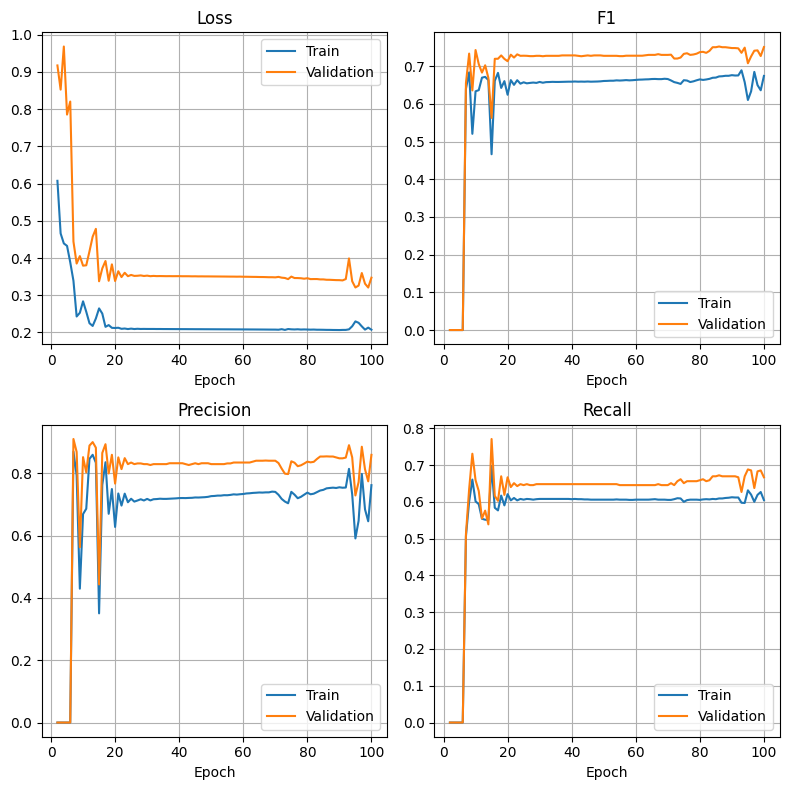

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

### Linear regression

In [51]:
from src.transformer import LinearRegressionAnomalyDetector

In [52]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 250

In [53]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


In [54]:
seed_everything(1)

input_dim = len(tr_cols) * window_size

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))
# loss_fn = nn.BCEWithLogitsLoss()

model_params = {
    "input_dim": input_dim,
    "learning_rate": 1e-5,
    "loss_fn": loss_fn,
}

model = LinearRegressionAnomalyDetector(
    **model_params,
)

Global seed set to 1


In [56]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt

  | Name    | Type              | Params
----------------------------------------------
0 | linear  | Linear            | 17    
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt


Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [58]:
mt = trainer.callbacks[1]

In [59]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

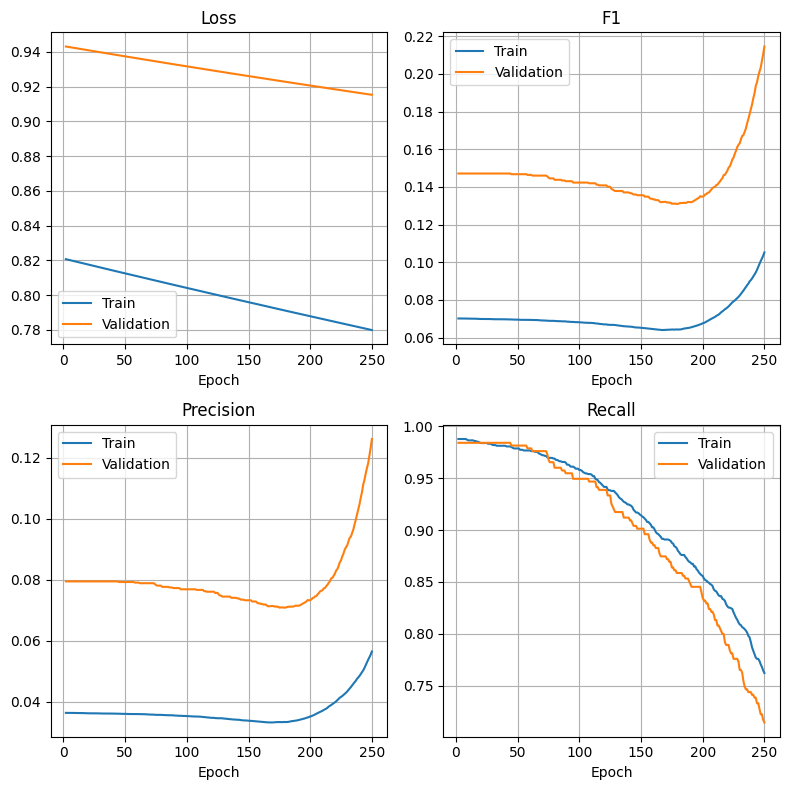

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

slightly worse, but works :)

### Linear attention

In [134]:
from src.transformer import LinearTransformerAnomalyDetector
from src.utils import GradNormCallback

In [126]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 150

In [127]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


In [128]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}

model = LinearTransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
layer norm disabled
positional encoding disabled


In [129]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(max_lr=1e-2), MetricTracker(), GradNormCallback()],
    gradient_clip_val=1.2,
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008709635899560806
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_4549a66a-9c2b-4664-85c0-7ee8ebbbfc30.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_4549a66a-9c2b-4664-85c0-7ee8ebbbfc30.ckpt

  | Name                | Type                     | Params
-----------------------------------------------------------------
0 | front_linear        | Linear                   | 24    
1 | transformer_encoder | LinearTransformerEncoder | 544   
2 | positional_encoder  | Identity                 | 0     
3 | final_linear        | Linear                   | 9     
4 | loss_fn             | BCEWithLogitsLoss        | 0     
-----------------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all st

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [130]:
mt = trainer.callbacks[1]

In [131]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

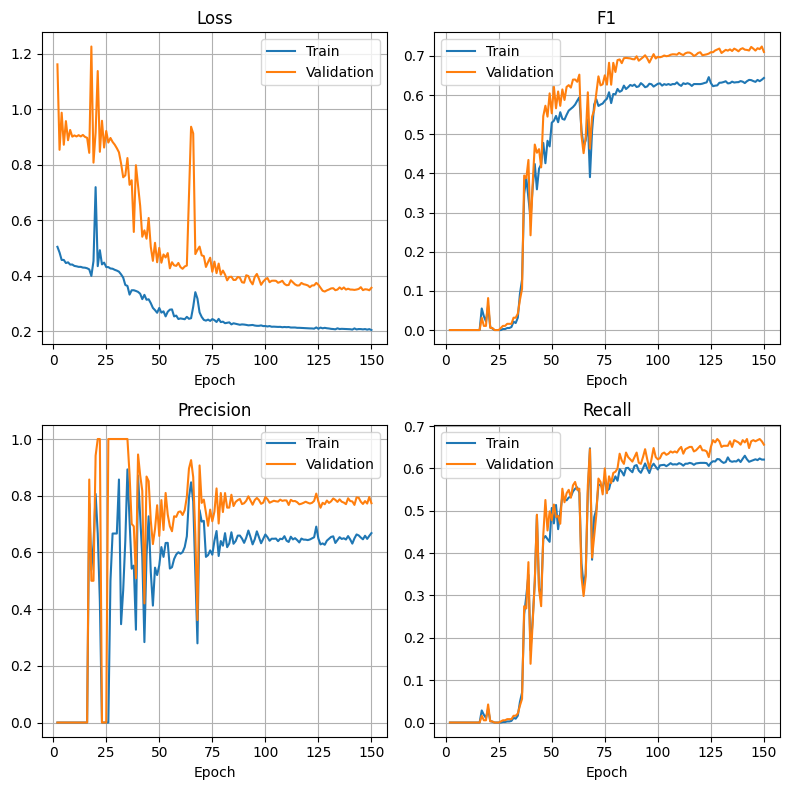

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

## Evaluate on all datasets

In [8]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [9]:
from src.utils import (
    get_metrics_from_tracker,
    plot_metrics_from_tracker,
    prepare_dataset_for_evaluation,
)

In [19]:
from lightning.pytorch.callbacks import LearningRateFinder

from src.utils import MetricTracker
from src.transformer import TransformerAnomalyDetector

In [20]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 100

In [21]:
dataset_name = "KPI"
tr_dl, va_dl, tr_cols = prepare_dataset_for_evaluation(
    dataset_name=dataset_name,
    window_size=8,
    train_proportion=0.9,
    batch_size=batch_size,
    root_data_dir=ROOT_DATA_DIR,
)

Global seed set to 1
Global seed set to 1


In [22]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "num_heads": 2,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}


model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
positional encoding disabled
layer norm disabled


In [23]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_c7d0a759-dac4-438e-9153-d47bb9952b19.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_c7d0a759-dac4-438e-9153-d47bb9952b19.ckpt

  | Name                | Type               | Params
-----------------------------------------------------------
0 | front_linear        | Linear             | 24    
1 | positional_encoder  | Identity           | 0     
2 | transformer_encoder | TransformerEncoder | 544   
3 | final_linear        | Linear             | 9     
4 | loss_fn             | BCEWithLogitsLoss  | 0     
-----------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/i

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [24]:
mt = trainer.callbacks[1]

In [25]:
res = get_metrics_from_tracker(mt)

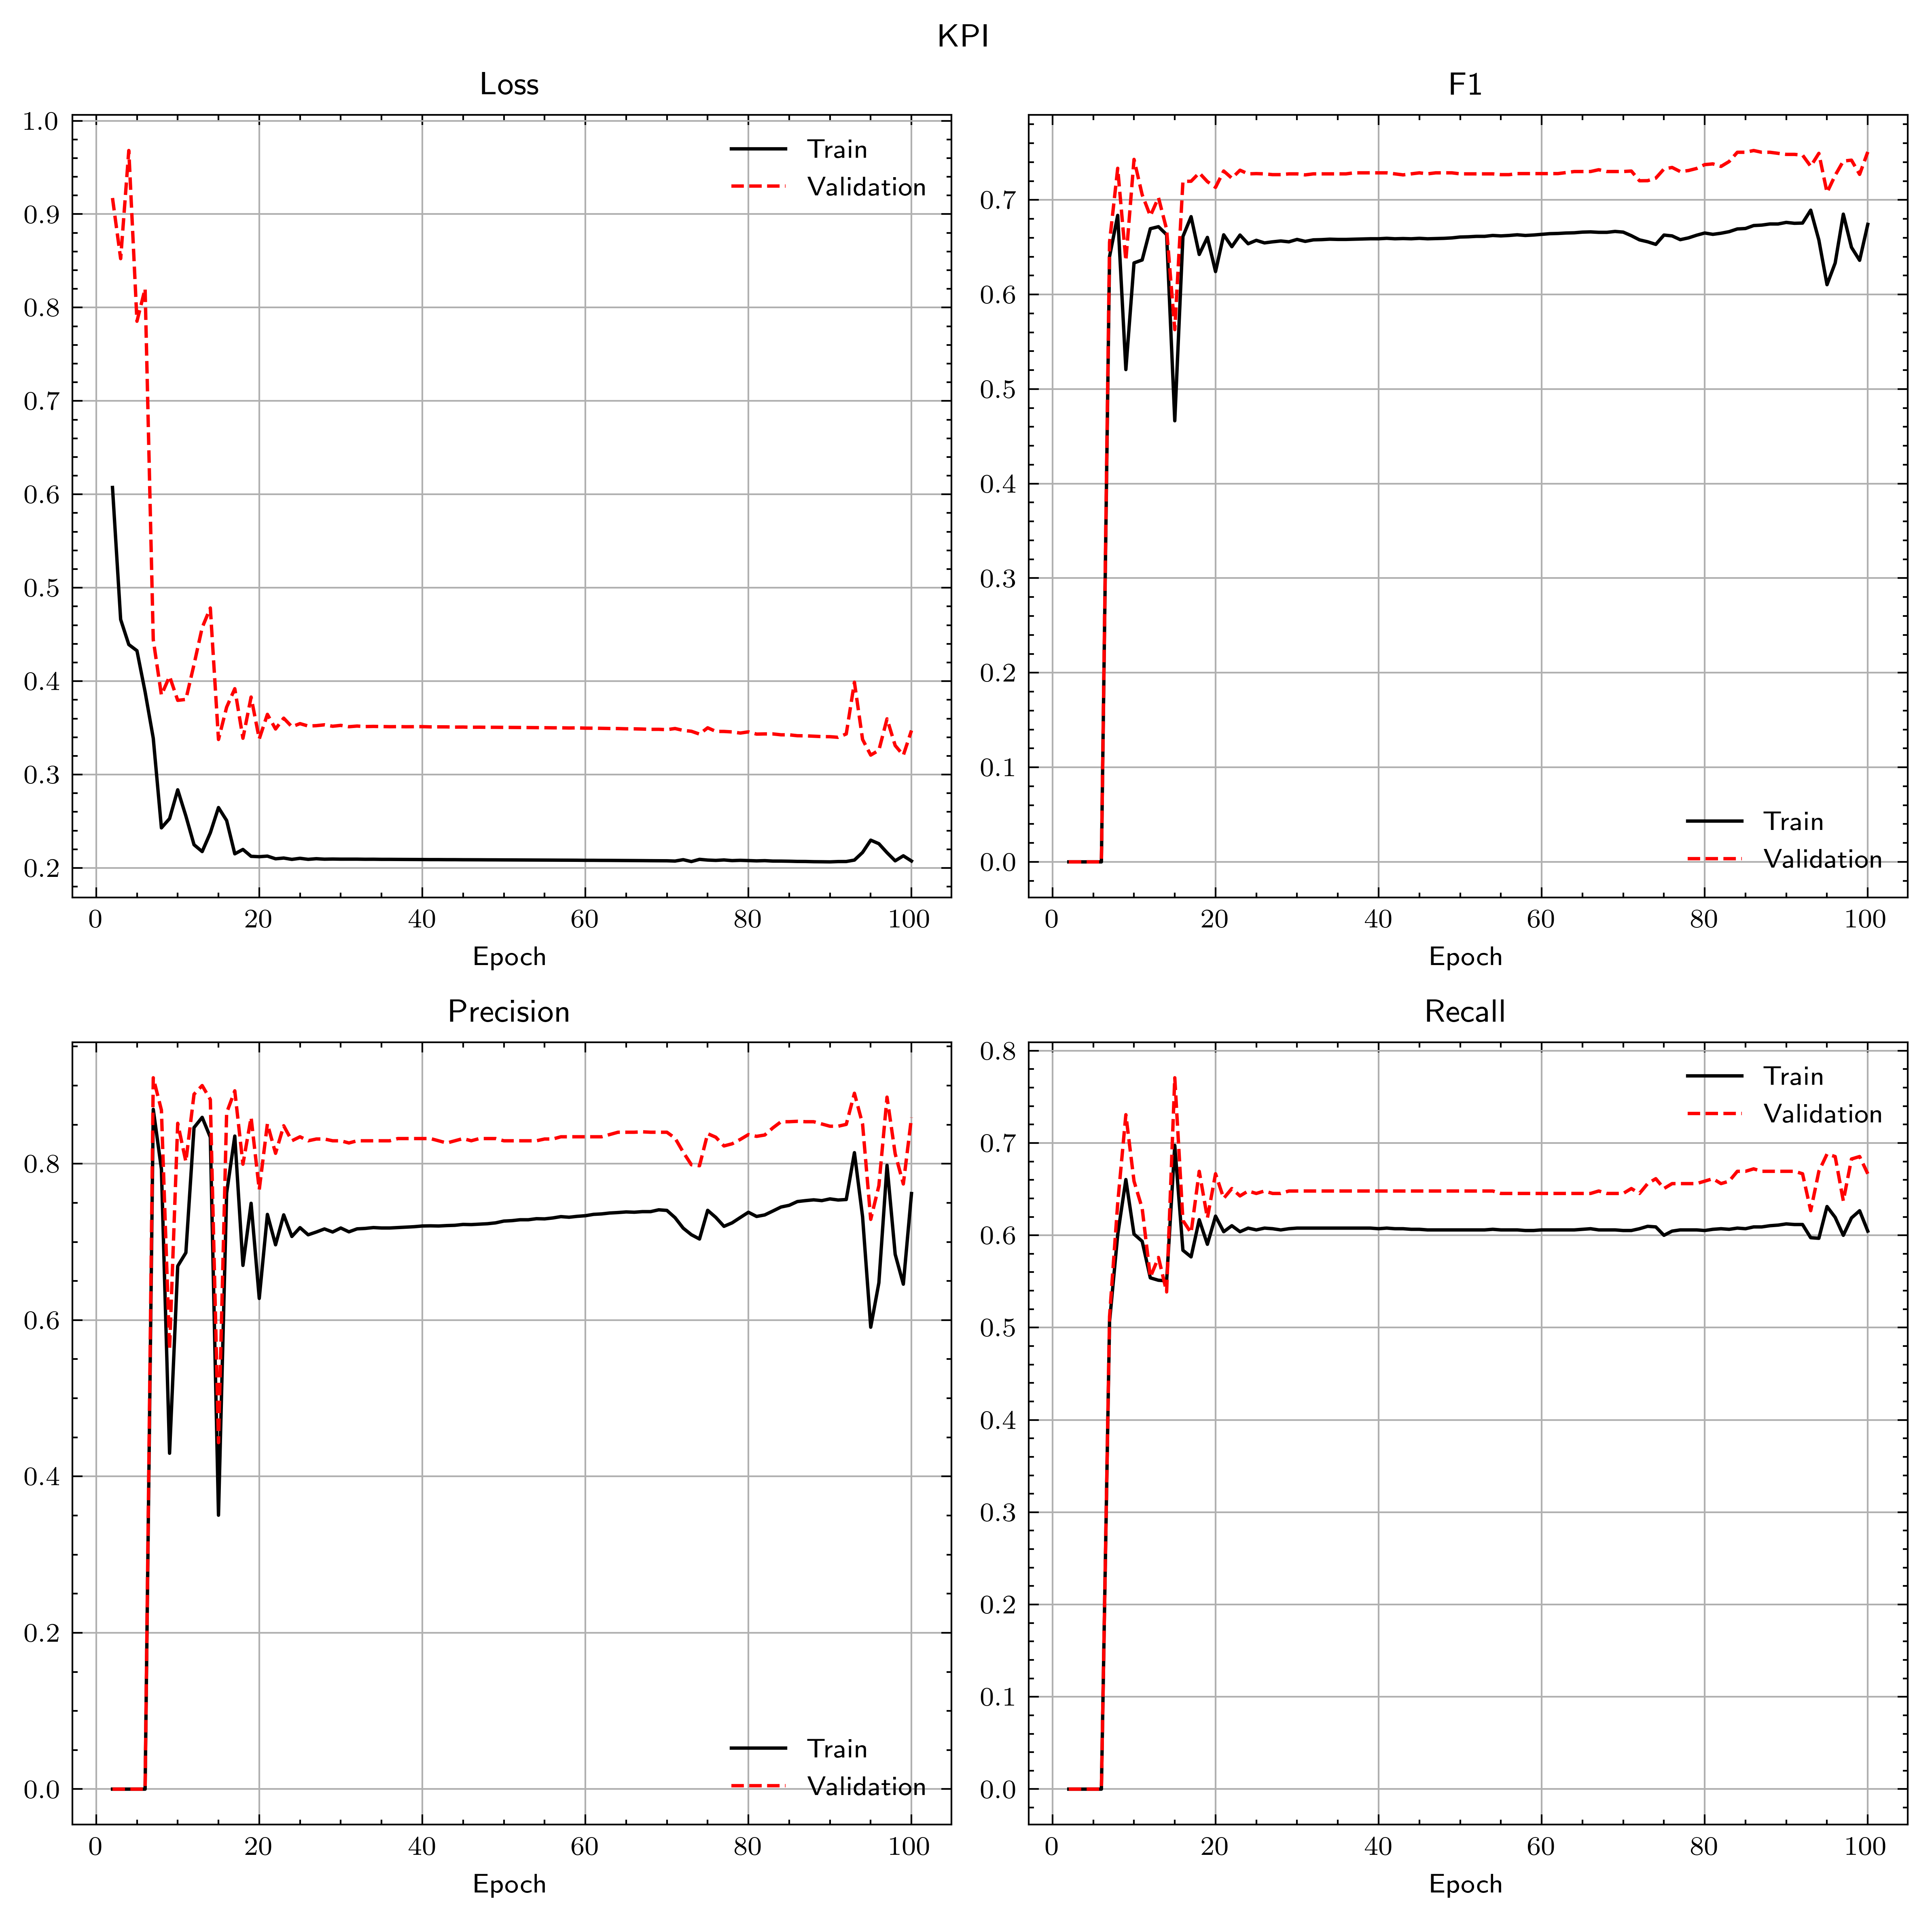

In [26]:
plot_metrics_from_tracker(res, dataset_name='KPI')